# Double descent - XGBoost

In [1]:
# core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# XGBoost
import xgboost as xgb

## Taxi dataset

### Processing taxi data

In [44]:
taxi_df = pd.read_csv('taxi_trip_pricing.csv')

In [45]:
taxi_df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [46]:
taxi_df = taxi_df.dropna(subset=['Trip_Price'])
y = taxi_df['Trip_Price']
taxi_df = taxi_df.drop(columns=['Trip_Price'])

In [47]:
for col in taxi_df.columns:
    if taxi_df[col].dtype == 'object':
        # Remplacer les valeurs manquantes par la classe majoritaire
        taxi_df[col].fillna(taxi_df[col].mode()[0], inplace=True)
    else:
        # Remplacer les valeurs manquantes par la médiane
        taxi_df[col].fillna(taxi_df[col].median(), inplace=True)

# 2. Appliquer le One-Hot Encoding sur certaines colonnes
one_hot_cols = ["Time_of_Day", "Day_of_Week", "Weather","Traffic_Conditions" ]  # Colonnes catégorielles pour One-Hot
one_hot_encoded = pd.get_dummies(taxi_df[one_hot_cols], prefix=one_hot_cols, dummy_na=False)

# 4. Fusionner le DataFrame avec les colonnes one-hot encodées
taxi_df = pd.concat([taxi_df, one_hot_encoded], axis=1)
X_df = taxi_df.drop(columns=one_hot_cols)

C:\Users\vince\AppData\Local\Temp\ipykernel_8784\111213894.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  taxi_df[col].fillna(taxi_df[col].median(), inplace=True)
C:\Users\vince\AppData\Local\Temp\ipykernel_8784\111213894.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

### XGBoost

[0]	train-rmse:30.14612	validation-rmse:29.20611
[10]	train-rmse:4.62346	validation-rmse:9.32726
[20]	train-rmse:3.11307	validation-rmse:9.06339
[30]	train-rmse:2.35363	validation-rmse:9.14030
[40]	train-rmse:1.85505	validation-rmse:9.26223
[50]	train-rmse:1.29416	validation-rmse:9.34349
[60]	train-rmse:1.00174	validation-rmse:9.37451
[70]	train-rmse:0.68216	validation-rmse:9.45911
[80]	train-rmse:0.47014	validation-rmse:9.45711
[90]	train-rmse:0.35174	validation-rmse:9.47713
[100]	train-rmse:0.26528	validation-rmse:9.48304
[110]	train-rmse:0.18958	validation-rmse:9.47811
[120]	train-rmse:0.12965	validation-rmse:9.48379
[130]	train-rmse:0.09977	validation-rmse:9.48381
[140]	train-rmse:0.07779	validation-rmse:9.48682
[150]	train-rmse:0.05870	validation-rmse:9.48950
[160]	train-rmse:0.04091	validation-rmse:9.48985
[170]	train-rmse:0.03511	validation-rmse:9.49102
[180]	train-rmse:0.02796	validation-rmse:9.49143
[190]	train-rmse:0.01873	validation-rmse:9.49181
[200]	train-rmse:0.01448	vali

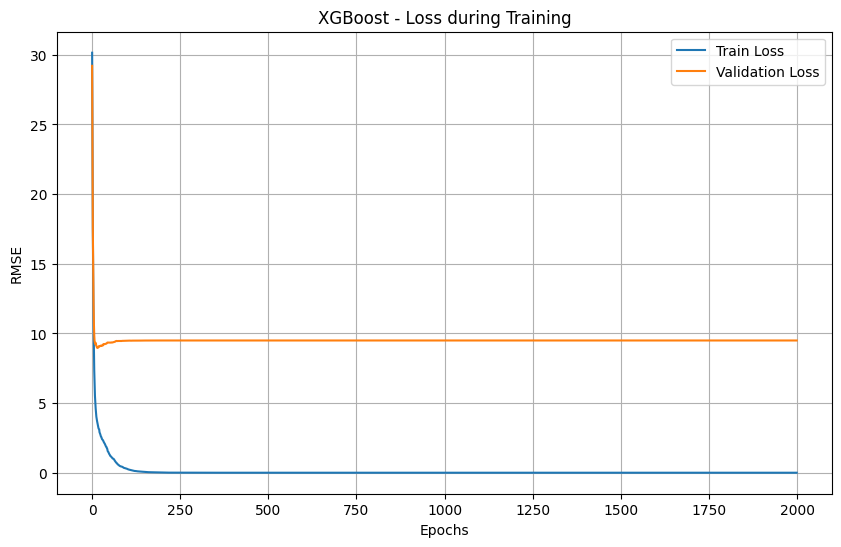

RMSE on Test Set: 90.11


In [ ]:
# 2. Division train/test
X_train, X_test, y_train, y_test = train_test_split(X_df.values, y, test_size=0.2, random_state=123)

# 3. Convertion in DMatrix (format XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

# 4. model parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.3,
    'eval_metric': 'rmse'
}

# 5. Dictionnaire pour stocker l'évolution des erreurs
evals_result = {}

# 6. Entraînement avec suivi de la perte
model = xgb.train(
    params,
    dtrain,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    num_boost_round=2000,
    early_stopping_rounds=2000,
    evals_result=evals_result,
    verbose_eval=100
)

# 7. Traçage des courbes de perte
epochs = len(evals_result['train']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['train']['rmse'], label='Train Loss')
plt.plot(x_axis, evals_result['validation']['rmse'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost - Loss during Training')
plt.legend()
plt.grid(True)
plt.show()

# 8. Prédictions et évaluation
y_pred = model.predict(dval)
rmse = mean_squared_error(y_test, y_pred)
print(f"RMSE on Test Set: {rmse:.2f}")


### Random Forest

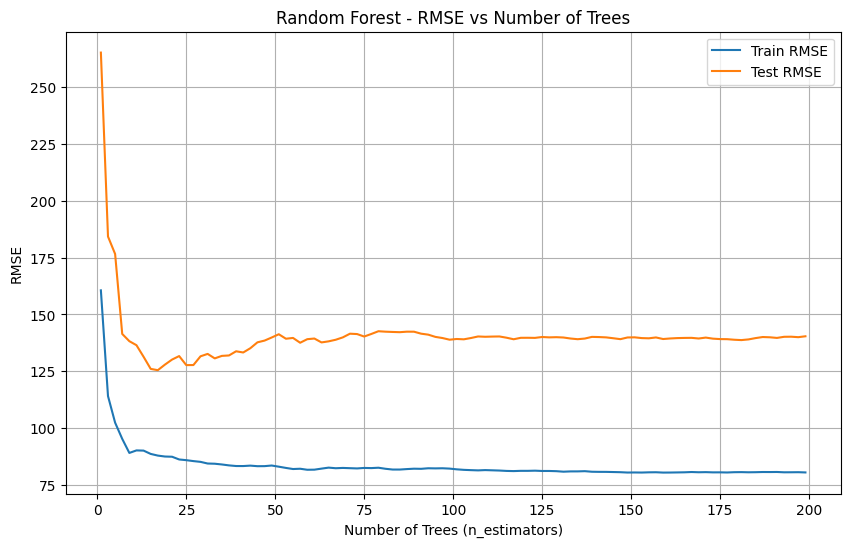

In [24]:
# 1. Division train/test
X_train, X_test, y_train, y_test = train_test_split(X_df.values, y, test_size=0.2, random_state=123)

# 2. Liste des nombres d'arbres à tester
n_trees = list(range(1, 200, 2))  # De 10 à 500 arbres par pas de 10
train_rmse_list = []
test_rmse_list = []

# 3. Boucle pour entraîner des Random Forest avec différents nombres d'arbres
for n in n_trees:
    rf_model = RandomForestRegressor(
        n_estimators=n,
        max_leaf_nodes=20,
        random_state=123,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    
    # Prédictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    
    # Calcul du RMSE
    train_rmse = mean_squared_error(y_train, y_pred_train)
    test_rmse = mean_squared_error(y_test, y_pred_test)
    
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

# 4. Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(n_trees, train_rmse_list, label='Train RMSE')
plt.plot(n_trees, test_rmse_list, label='Test RMSE')

plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE')
plt.title('Random Forest - RMSE vs Number of Trees')
plt.legend()
plt.grid(True)
plt.show()


### Adaboost

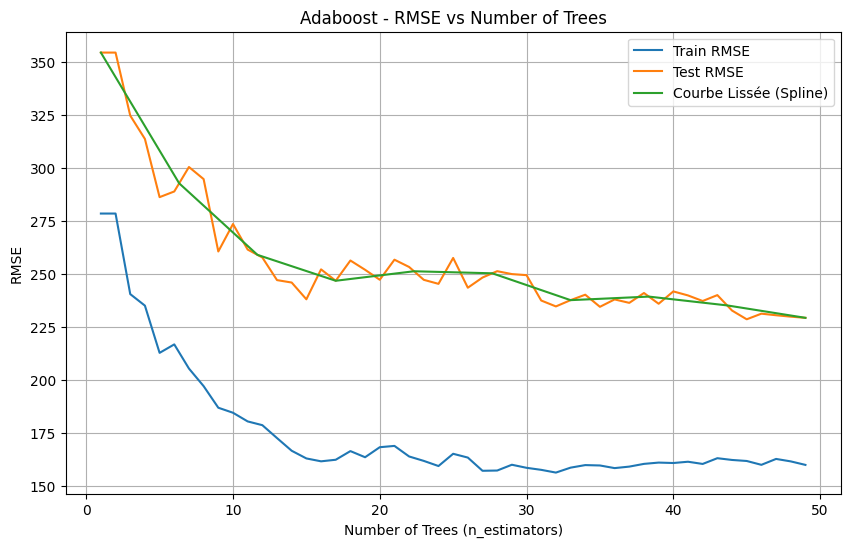

In [55]:
from sklearn.ensemble import AdaBoostRegressor
from scipy.interpolate import make_interp_spline

# 1. Division train/test
X_train, X_test, y_train, y_test = train_test_split(X_df.values, y, test_size=0.2, random_state=123)

# 2. Liste des nombres d'arbres à tester
n_trees = list(range(1, 50))  # De 10 à 500 arbres par pas de 10
train_rmse_list = []
test_rmse_list = []

# 3. Boucle pour entraîner des Random Forest avec différents nombres d'arbres
for n in n_trees:
    ada_model = AdaBoostRegressor(
        n_estimators=n,
        random_state=123,
    )
    
    ada_model.fit(X_train, y_train)
    
    # Prédictions
    y_pred_train = ada_model.predict(X_train)
    y_pred_test = ada_model.predict(X_test)
    
    # Calcul du RMSE
    train_rmse = mean_squared_error(y_train, y_pred_train)
    test_rmse = mean_squared_error(y_test, y_pred_test)
    
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

# 4. Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(n_trees, train_rmse_list, label='Train RMSE')
plt.plot(n_trees, test_rmse_list, label='Test RMSE')
# Interpolation spline

# Interpolation spline
x_smooth = np.linspace(min(n_trees), max(n_trees), 10)  # Génère plus de points
spline = make_interp_spline(n_trees, test_rmse_list, k=1)  # k=3 pour une spline cubique
y_smooth = spline(x_smooth)
# Tracé des courbes
plt.plot(x_smooth, y_smooth, '-', label='Courbe Lissée (Spline)')

plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE')
plt.title('Adaboost - RMSE vs Number of Trees')
plt.legend()
plt.grid(True)
plt.show()


## Artificial Dataset

### Linear regression

Degree 1 - Train MSE: 0.5968, Test MSE: 0.5871
Degree 2 - Train MSE: 0.5872, Test MSE: 0.6033
Degree 3 - Train MSE: 0.5638, Test MSE: 0.6201
Degree 4 - Train MSE: 0.4197, Test MSE: 0.6318
Degree 5 - Train MSE: 0.3579, Test MSE: 1.0334
Degree 6 - Train MSE: 0.1497, Test MSE: 0.2889
Degree 7 - Train MSE: 0.1052, Test MSE: 1.4781
Degree 8 - Train MSE: 0.0666, Test MSE: 0.3649
Degree 9 - Train MSE: 0.0590, Test MSE: 2.0183
Degree 10 - Train MSE: 0.0506, Test MSE: 3.8003
Degree 11 - Train MSE: 0.0397, Test MSE: 28.4131
Degree 12 - Train MSE: 0.0293, Test MSE: 167.4484
Degree 13 - Train MSE: 0.0180, Test MSE: 7809.0328
Degree 14 - Train MSE: 0.0026, Test MSE: 922329.7417
Degree 15 - Train MSE: 0.0000, Test MSE: 13655014.4864
Degree 16 - Train MSE: 0.0000, Test MSE: 185085042.7074
Degree 17 - Train MSE: 0.0000, Test MSE: 2075325743.4265
Degree 18 - Train MSE: 0.0000, Test MSE: 23819351108.4673
Degree 19 - Train MSE: 0.0000, Test MSE: 123921222239.5043


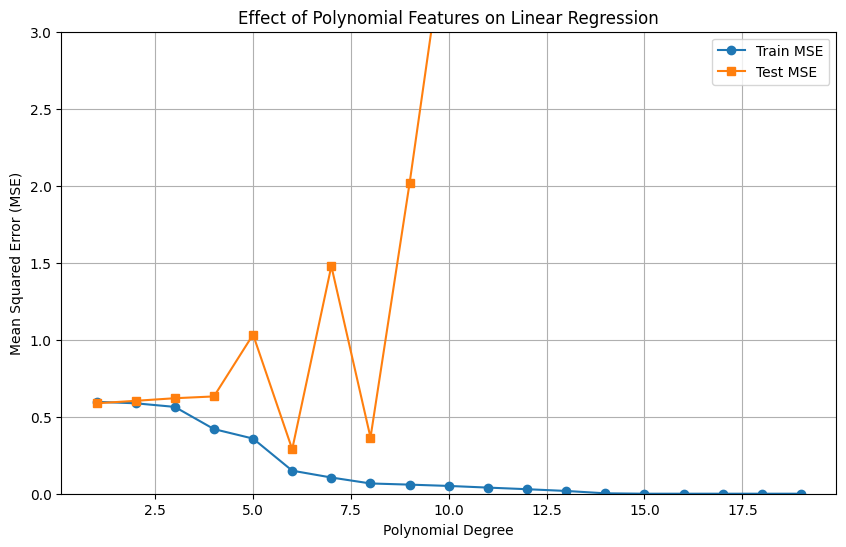

In [66]:
from sklearn.preprocessing import PolynomialFeatures

# 1. Génération du dataset synthétique
np.random.seed(123)
n_samples = 1000

X = np.random.uniform(-np.pi, np.pi, size=(n_samples, 3))  # X1, X2, X3 uniformes entre 0 et 2pi
y = np.cos(X[:, 0] + X[:, 1] + X[:, 2]) + np.random.normal(0, 0.3, n_samples)  # y = cos(X1 + X2 + X3) + bruit

# 2 Division en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 3. Ajout de features polynomiales et suivi du MSE
degrees = range(1, 20)  # Ajouter des polynômes jusqu'au degré 6
train_mse = []
test_mse = []

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=True)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Régression linéaire avec features augmentées
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Prédictions et calcul des MSE
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))
    print(f"Degree {d} - Train MSE: {train_mse[-1]:.4f}, Test MSE: {test_mse[-1]:.4f}")

# 4. Visualisation des MSE (Train vs Test)
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_mse, label='Train MSE', marker='o')
plt.plot(degrees, test_mse, label='Test MSE', marker='s')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Effect of Polynomial Features on Linear Regression')
plt.legend()
plt.ylim(0, 3)
plt.grid(True)
plt.show()


### XGBoost

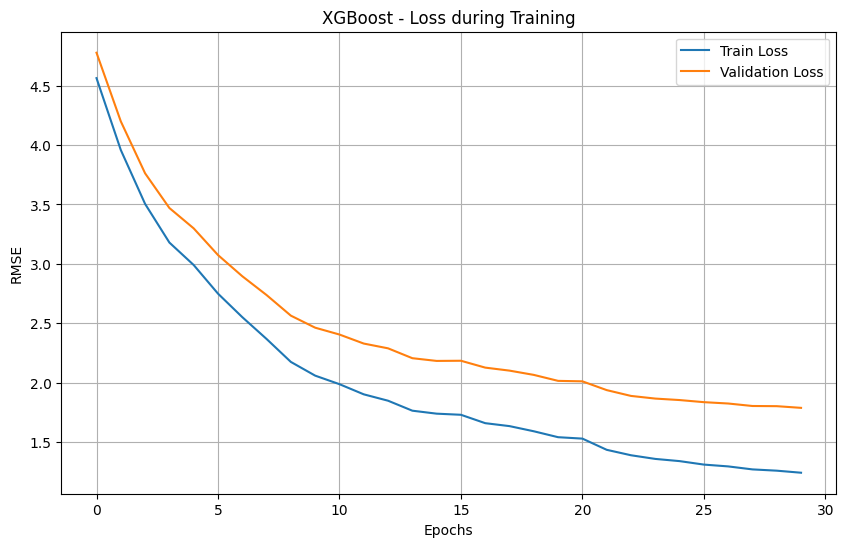

RMSE on Test Set: 3.19


In [73]:
# 1. Génération du dataset synthétique
np.random.seed(123)
n_samples = 10000

X = np.random.uniform(-np.pi, np.pi, size=(n_samples, 3))  # X1, X2, X3 uniformes entre 0 et 2pi
y = np.cos(X[:, 0] + X[:, 1] + X[:, 2])*X[:,1]**2*X[:,2] + np.random.normal(0, 0.3, n_samples)  # y = cos(X1 + X2 + X3) + bruit

# 2. Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# 3. Convertion in DMatrix (format XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

# 4. model parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.3,
    'eval_metric': 'rmse'
}

# 5. Dictionnaire pour stocker l'évolution des erreurs
evals_result = {}

# 6. Entraînement avec suivi de la perte
model = xgb.train(
    params,
    dtrain,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    num_boost_round=30,
    early_stopping_rounds=30,
    evals_result=evals_result,
    verbose_eval=None
)

# 7. Traçage des courbes de perte
epochs = len(evals_result['train']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['train']['rmse'], label='Train Loss')
plt.plot(x_axis, evals_result['validation']['rmse'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost - Loss during Training')
plt.legend()
plt.grid(True)
plt.show()

# 8. Prédictions et évaluation
y_pred = model.predict(dval)
rmse = mean_squared_error(y_test, y_pred)
print(f"RMSE on Test Set: {rmse:.2f}")


### Random forest

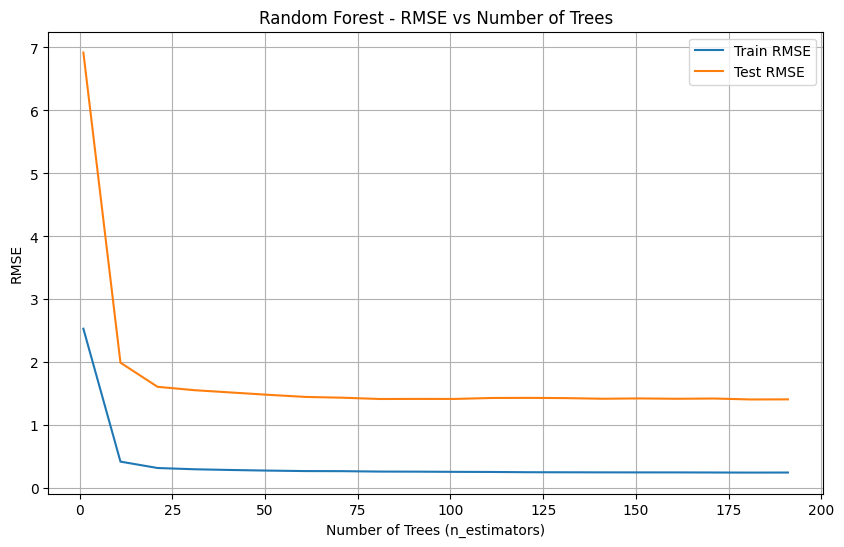

In [77]:
# 1. Génération du dataset synthétique
np.random.seed(123)
n_samples = 10000

X = np.random.uniform(-np.pi, np.pi, size=(n_samples, 3))  # X1, X2, X3 uniformes entre 0 et 2pi
y = np.cos(X[:, 0] + X[:, 1] + X[:, 2])*X[:,1]**2*X[:,2] + np.random.normal(0, 0.3, n_samples)  # y = cos(X1 + X2 + X3) + bruit

# 2. Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# 2. Liste des nombres d'arbres à tester
n_trees = list(range(1, 200, 10))  # De 10 à 500 arbres par pas de 10
train_rmse_list = []
test_rmse_list = []

# 3. Boucle pour entraîner des Random Forest avec différents nombres d'arbres
for n in n_trees:
    rf_model = RandomForestRegressor(
        n_estimators=n,
        max_depth=None,
        random_state=123,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    
    # Prédictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    
    # Calcul du RMSE
    train_rmse = mean_squared_error(y_train, y_pred_train)
    test_rmse = mean_squared_error(y_test, y_pred_test)
    
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

# 4. Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(n_trees, train_rmse_list, label='Train RMSE')
plt.plot(n_trees, test_rmse_list, label='Test RMSE')

plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE')
plt.title('Random Forest - RMSE vs Number of Trees')
plt.legend()
plt.grid(True)
plt.show()


### MLP

In [78]:
from tensorflow import keras
from tensorflow.keras import layers

# 1. Génération du dataset synthétique
np.random.seed(123)
n_samples = 10000

X = np.random.uniform(-np.pi, np.pi, size=(n_samples, 3))  # X1, X2, X3
y = np.cos(X[:, 0] + X[:, 1] + X[:, 2]) * X[:, 1]**2 * X[:, 2] + np.random.normal(0, 0.3, n_samples)

# 2. Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# 3. Liste des nombres de neurones à tester
neurons_list = list(range(10, 300, 20))  # De 10 à 300 neurones par pas de 20
train_rmse_list = []
test_rmse_list = []

# 4. Boucle pour entraîner des MLP avec différents nombres de neurones
for n in neurons_list:
    model = keras.Sequential([
        layers.Dense(n, activation='relu', input_shape=(3,)),  # Première couche avec n neurones
        layers.Dense(n, activation='relu'),                     # Deuxième couche avec n neurones
        layers.Dense(1)                                         # Sortie
    ])
    
    model.compile(optimizer='adam', loss='mse')
    
    # Entraînement du modèle
    model.fit(X_train, y_train, epochs=10, verbose=0, batch_size=32)
    
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calcul du RMSE
    train_rmse = mean_squared_error(y_train, y_pred_train)
    test_rmse = mean_squared_error(y_test, y_pred_test)
    
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

# 5. Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(neurons_list, train_rmse_list, label='Train RMSE')
plt.plot(neurons_list, test_rmse_list, label='Test RMSE')

plt.xlabel('Number of Neurons (per layer)')
plt.ylabel('RMSE')
plt.title('MLP - RMSE vs Number of Neurons')
plt.legend()
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'tensorflow'